# Download Dataset from Kaggle

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("karakaggle/kaggle-cat-vs-dog-dataset")

print("Path to dataset files:", path)

100%|██████████| 787M/787M [00:09<00:00, 86.6MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/karakaggle/kaggle-cat-vs-dog-dataset/versions/1


In [4]:
! cp -r /root/.cache/kagglehub/datasets/karakaggle/kaggle-cat-vs-dog-dataset/versions/1 .

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from pathlib import Path
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import mobilenet_v2
from tensorflow.keras.callbacks import EarlyStopping

In [5]:
img_path = Path('PetImages')

In [6]:
file_paths = list(map(str, img_path.glob('*/*.jpg')))
label = list(map(lambda x: x.split('/')[1], file_paths))
image_df = pd.DataFrame({'path':file_paths, 'label':label})
image_df.head()
image_df['label'].value_counts()

,count
label,
Cat,12490
Dog,12469


In [7]:
train_df, test_df = train_test_split(image_df, test_size=0.2, random_state=42)

In [8]:
def pre_processing(img):
  img = np.array(img) / 255.0
  return img

In [9]:
train_generator = ImageDataGenerator(
    preprocessing_function=pre_processing,
    validation_split=0.2
)
test_generator = ImageDataGenerator(
    preprocessing_function=pre_processing
)

In [16]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='path',
    y_col='label',
    batch_size=64,
    target_size=(224,224),
    class_mode='binary',
    color_mode='rgb',
    shuffle=True,
    seed=42,
    subset='training'
)
valid_images = train_generator.flow_from_dataframe(
   dataframe=train_df,
    x_col='path',
    y_col='label',
    batch_size=64,
    target_size=(224,224),
    class_mode='binary',
    color_mode='rgb',
    shuffle=True,
    seed=42,
    subset='validation'
)
test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='path',
    y_col='label',
    batch_size=64,
    target_size=(224,224),
    class_mode='binary',
    shuffle=False
)

Found 15974 validated image filenames belonging to 2 classes.
Found 3993 validated image filenames belonging to 2 classes.
Found 4992 validated image filenames belonging to 2 classes.


# transfer Learning

In [11]:
base_model = mobilenet_v2.MobileNetV2(
    input_shape=(224,224,3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)
base_model.trainable = False
# base_model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [12]:
tl_model = Sequential([
  base_model,
  Dense(64, activation='relu'),
  Dropout(0.2),
  Dense(1, activation='sigmoid')
])
tl_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
tl_model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 1280)           │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        81,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,340,033 (8.93 MB)

 Trainable params: 82,049 (320.50 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [13]:
history = tl_model.fit(
    train_images, validation_data=valid_images, epochs=10,
    callbacks=[
        EarlyStopping(monitor='val_loss',patience=3, restore_best_weights=True)
    ]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
155/250 ━━━━━━━━━━━━━━━━━━━━ 27s 289ms/step - accuracy: 0.9447 - loss: 0.1313

/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


250/250 ━━━━━━━━━━━━━━━━━━━━ 102s 358ms/step - accuracy: 0.9559 - loss: 0.1078 - val_accuracy: 0.9840 - val_loss: 0.0504
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 97s 211ms/step - accuracy: 0.9826 - loss: 0.0435 - val_accuracy: 0.9855 - val_loss: 0.0471
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 55s 218ms/step - accuracy: 0.9897 - loss: 0.0298 - val_accuracy: 0.9860 - val_loss: 0.0424
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 53s 211ms/step - accuracy: 0.9916 - loss: 0.0246 - val_accuracy: 0.9840 - val_loss: 0.0488
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 56s 225ms/step - accuracy: 0.9924 - loss: 0.0216 - val_accuracy: 0.9830 - val_loss: 0.0543
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 51s 204ms/step - accuracy: 0.9939 - loss: 0.0184 - val_accuracy: 0.9852 - val_loss: 0.0538


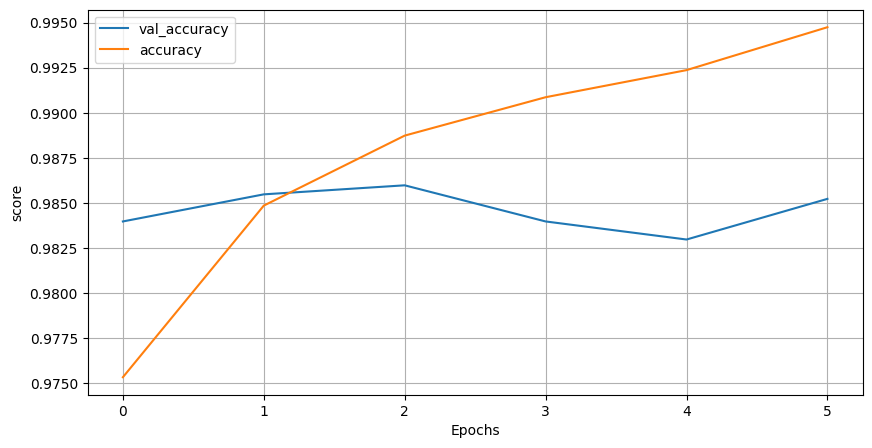

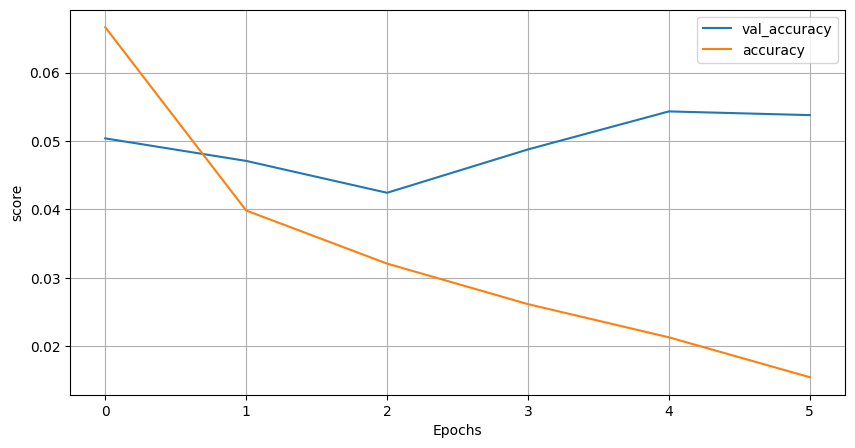

In [14]:
def plot_accuracy(history):
  plt.figure(figsize=(10,5))
  plt.plot(history['val_accuracy'])
  plt.plot(history['accuracy'])
  plt.legend(['val_accuracy','accuracy'])
  plt.xlabel('Epochs')
  plt.ylabel('score')
  plt.grid(True)
  plt.show()
def plot_loss(history):
  plt.figure(figsize=(10,5))
  plt.plot(history['val_loss'])
  plt.plot(history['loss'])
  plt.legend(['val_accuracy','accuracy'])
  plt.xlabel('Epochs')
  plt.ylabel('score')
  plt.grid(True)
  plt.show()

In [28]:
tl_y_pred = tl_model.predict(test_images)
tl_y_pred = np.where(tl_y_pred>0.5,1,0)
tl_cm = confusion_matrix(test_images.labels, tl_y_pred)

78/78 ━━━━━━━━━━━━━━━━━━━━ 15s 197ms/step


In [26]:
def plot_confusion_matrix(cm):
  plt.figure(figsize=(5,8))
  sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False)
  plt.xlabel('Predicted')
  plt.ylabel('Actual')
  plt.show()

In [19]:
tl_model.save('dog_vs_cat.h5')

# custom Model

In [20]:
custom_model = Sequential([
    # Conv Block 1
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    # Conv Block 2
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    # Conv Block 3
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),

    # Fully Connected Layer
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # For binary classification
])
custom_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
custom_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 52, 52, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,985 (42.61 MB)

 Trainable params: 11,169,537 (42.61 MB)

 Non-trainable params: 448 (1.75 KB)

In [21]:
custom_history = custom_model.fit(
    train_images, validation_data=valid_images, epochs=10,
    callbacks=[
        EarlyStopping(monitor='val_loss',patience=3, restore_best_weights=True)
        ]
    )

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
 85/250 ━━━━━━━━━━━━━━━━━━━━ 37s 225ms/step - accuracy: 0.5507 - loss: 6.9534

/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


250/250 ━━━━━━━━━━━━━━━━━━━━ 80s 274ms/step - accuracy: 0.5598 - loss: 3.7357 - val_accuracy: 0.5938 - val_loss: 0.8201
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 66s 264ms/step - accuracy: 0.6448 - loss: 0.6634 - val_accuracy: 0.6161 - val_loss: 0.8948
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 57s 228ms/step - accuracy: 0.6638 - loss: 0.6287 - val_accuracy: 0.6531 - val_loss: 0.7059
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 56s 224ms/step - accuracy: 0.7146 - loss: 0.5747 - val_accuracy: 0.6985 - val_loss: 0.9307
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 53s 213ms/step - accuracy: 0.7372 - loss: 0.5117 - val_accuracy: 0.7814 - val_loss: 0.4879
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 66s 265ms/step - accuracy: 0.7601 - loss: 0.4699 - val_accuracy: 0.7779 - val_loss: 0.4830
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 56s 223ms/step - accuracy: 0.7895 - loss: 0.4296 - val_accuracy: 0.8102 - val_loss: 0.4572
Epoch 8/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 57s 229ms/step - accuracy: 0.8027 - loss: 0.4008 - val

In [31]:
y_pred = custom_model.predict(test_images)
cs_y_pred = np.where(y_pred>0.5,1,0)
cs_cm = confusion_matrix(test_images.labels, cs_y_pred)

78/78 ━━━━━━━━━━━━━━━━━━━━ 16s 209ms/step


              precision    recall  f1-score   support

           0       0.75      0.86      0.80      2456
           1       0.84      0.72      0.78      2536

    accuracy                           0.79      4992
   macro avg       0.80      0.79      0.79      4992
weighted avg       0.80      0.79      0.79      4992

              precision    recall  f1-score   support

           0       0.98      0.97      0.98      2456
           1       0.97      0.98      0.98      2536

    accuracy                           0.98      4992
   macro avg       0.98      0.98      0.98      4992
weighted avg       0.98      0.98      0.98      4992



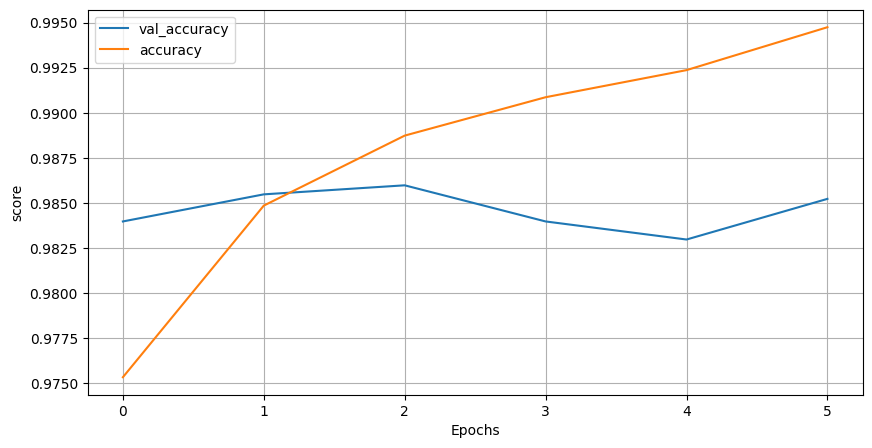

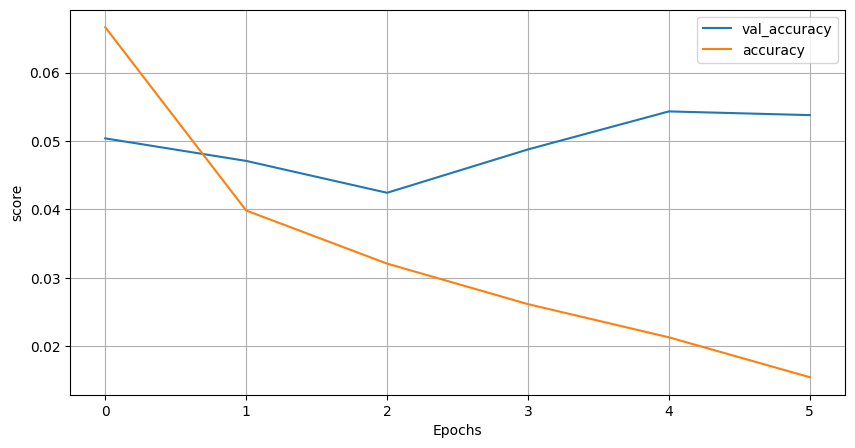

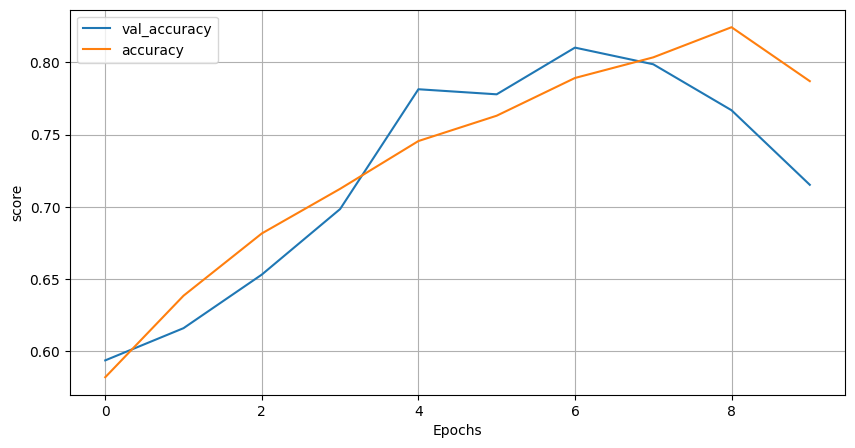

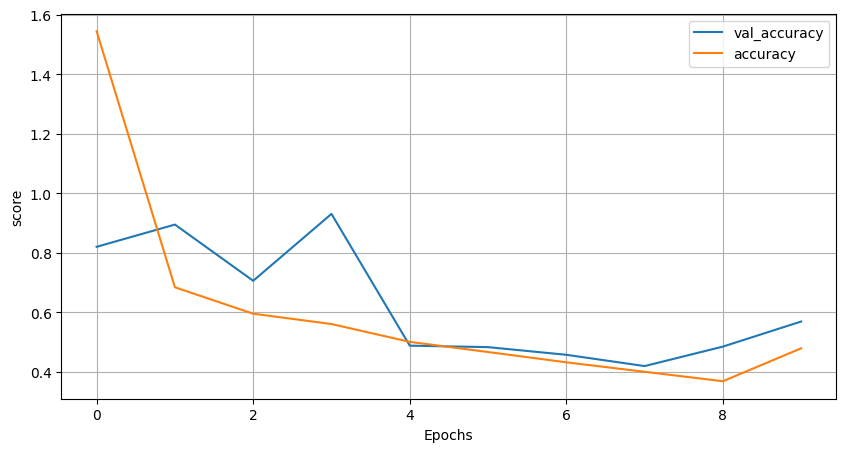

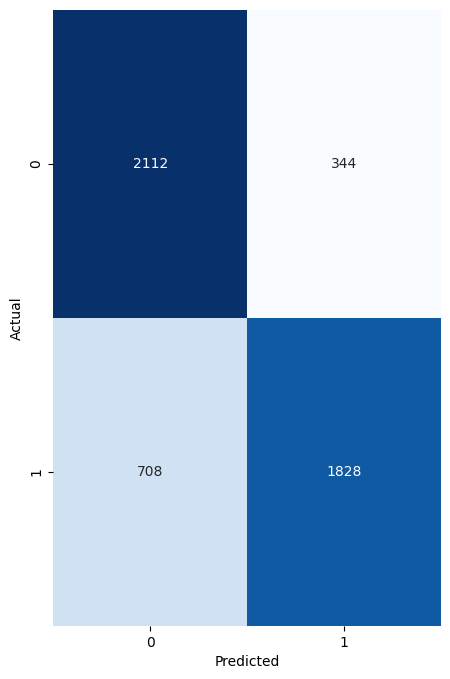

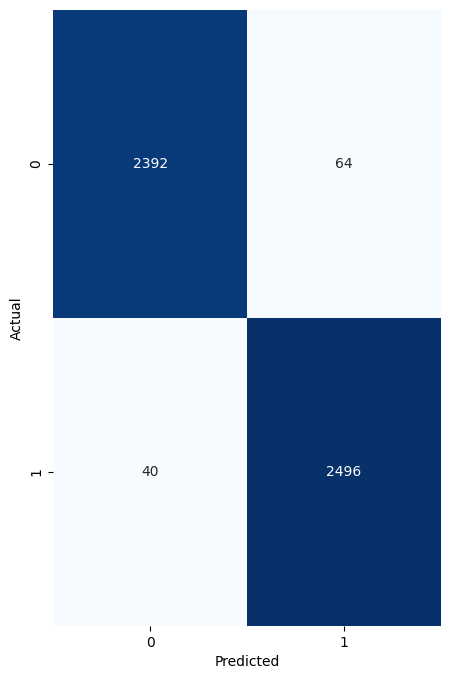

In [32]:
print(classification_report(test_images.labels, cs_y_pred))
print(classification_report(test_images.labels, tl_y_pred))
plot_accuracy(history.history)
plot_loss(history.history)
plot_accuracy(custom_history.history)
plot_loss(custom_history.history)
plot_confusion_matrix(cs_cm)
plot_confusion_matrix(tl_cm)